# Airbnb Data Analysis

Data from [Inside Airbnb](http://insideairbnb.com/get-the-data.html)

Command to convert the ipynb to rmkdwn : ```rmarkdown:::convert_ipynb('Airbnb Data Analysis.ipynb')```


## Equipe

Sorrin Marius

Marini Camille

Barras Pierre-Mathieu

## Data Preparation
1. Prepare data set for each city
2. Clean data for each city

In [1]:
library(dplyr)
# issue with this one
library(stringr)
library(ggplot2)
library(data.table)
library(repr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [2]:
# Choosing size of ggplot panels layout
options(repr.plot.width = 10, repr.plot.height = 5)

In [3]:
# Function from the data_prep script

# a generic function to prepare data for a specific city, data_date
prepare_data <- function(city, data_date)
{
    # Cleaning listings dataframe
    
    # suppose raw data is stored in data_raw/city/data_date/listings.csv.gz
    listings_url <- file.path("data_raw", city, data_date, "listings.csv.gz")
    # suppose raw data is stored in data_raw/city/data_date/calendar.csv.gz
    calendar_url <- file.path("data_raw", city, data_date, "calendar.csv.gz")
    
    print(paste0("reading data from ", listings_url))
    listings <- read.csv(gzfile(listings_url))
    print(paste0("reading data from ", calendar_url))
    calendar <- read.csv(gzfile(calendar_url))
    
    ## Add Keys: columns city and day date
    listings$city <- city
    listings$data_date <- data_date
    
    ## Select interesting columns
    ### Most columns don't contain interesting information
    columns_listings <- c("city", "data_date", "id", "neighbourhood_cleansed", 
                          "latitude", "longitude", 
                          "property_type", "room_type", "accommodates", "bedrooms", 
                          "beds", "price", "minimum_nights",  "maximum_nights")
    
    listings <- listings %>% 
        select(columns_listings) %>% 
        arrange(id)
    
    
    # Cleaning calendar dataframe
    
    ## arrange by id and date
    calendar <- calendar %>% 
        arrange(listing_id, date)
    
    ## add day number (starting first day)
    calendar <- calendar %>%
        group_by(listing_id) %>%
        mutate(day_nb = row_number()) %>%
        ungroup()
    
    ## change available column to binary
    calendar <- calendar %>%
        mutate(available = ifelse(available=="t", 1, 0))
    
    ## clean price column and transform to numeric
    calendar <- calendar %>%
        mutate(price = str_replace(price, "\\$", ""),
               adjusted_price = str_replace(adjusted_price, "\\$", ""))
    calendar <- calendar %>%
        mutate(price = str_replace(price, ",", ""),
               adjusted_price = str_replace(adjusted_price, ",", ""))
    calendar <- calendar %>%
        mutate(price = as.numeric(price),
               adjusted_price = as.numeric(adjusted_price))
    
    ## calculate estimated revenue for upcoming day
    calendar <- calendar %>%
        mutate(revenue = price*(1-available))
    
    ## calculate availability, price, revenue for next 30, 60 days ... for each listing_id
    calendar <- calendar %>%
        group_by(listing_id) %>%
        summarise(availability_30 = sum(available[day_nb<=30], na.rm = TRUE),
                  availability_60 = sum(available[day_nb<=60], na.rm = TRUE),
                  availability_90 = sum(available[day_nb<=90], na.rm = TRUE),
                  availability_365 = sum(available[day_nb<=365], na.rm = TRUE),
                  price_30 = mean(price[day_nb<=30 & available==0], na.rm = TRUE),
                  price_60 = mean(price[day_nb<=60 & available==0], na.rm = TRUE),
                  price_90 = mean(price[day_nb<=90 & available==0], na.rm = TRUE),
                  price_365 = mean(price[day_nb<=365 & available==0], na.rm = TRUE),
                  revenue_30 = sum(revenue[day_nb<=30], na.rm = TRUE),
                  revenue_60 = sum(revenue[day_nb<=60], na.rm = TRUE),
                  revenue_90 = sum(revenue[day_nb<=90], na.rm = TRUE),
                  revenue_365 = sum(revenue[day_nb<=365], na.rm = TRUE)           
        )
    
    listings_cleansed <- listings %>% left_join(calendar, by = c("id" = "listing_id"))
    
    dir.create(file.path("data_cleansed", city, data_date), recursive = TRUE)
    
    write.csv(listings_cleansed, file.path("data_cleansed", city, data_date, "listings.csv"))
    print(paste0("saving data into ", file.path("data_cleansed", city, data_date, "listings.csv")))
    
}  

# Prepare data for all selected cities 

In [4]:
# Reading cleansed data
cities <- c("malaga", "mallorca", "sevilla")
data_dates <- c("2020-06-30", "2020-09-19", "2020-06-29")

# We are only interested in data between min_date and max_date
min_date <- '2020-05-01'
max_date <- '2020-11-01'

files_paths <- c()

### Preparare data for Malaga, mallorca, sevilla

In [5]:
for(i in 1:length(cities)){
    city <- cities[i]
    data_date <- data_dates[i]
    print("-------------------------------------------------")
    print(paste(c("Preparing data for", city, "compiled at", data_date), collapse = " "))
    # prepare_data(city, data_date)
}

# Clean Environment
rm(list=ls())

[1] "-------------------------------------------------"
[1] "Preparing data for malaga compiled at 2020-06-30"
[1] "-------------------------------------------------"
[1] "Preparing data for mallorca compiled at 2020-09-19"
[1] "-------------------------------------------------"
[1] "Preparing data for sevilla compiled at 2020-06-29"


In [6]:
# Reading cleansed data
cities <- c("malaga", "mallorca", "sevilla")
data_dates <- c("2020-06-30", "2020-09-19", "2020-06-29")

# We are only interested in data between min_date and max_date
min_date <- '2020-05-01'
max_date <- '2020-11-01'

files_paths <- c()

### Read data in cities between min_date and max_date

In [7]:
for(city in cities){
    file_dir <- file.path(".", "data_cleansed", city)
    file_subdirs <- list.dirs(file_dir)
    file_subdirs <- file_subdirs[-1]

    for(file_subdir in file_subdirs){
        if(file_subdir < file.path(file_dir, min_date) | file_subdir > file.path(file_dir, max_date)  )
            file_subdirs = file_subdirs[file_subdirs != file_subdir]
    }
    files_paths <- c(files_paths, file_subdirs)
}
files_paths <- file.path(files_paths, "listings.csv")
listings <- 
    do.call(rbind,
            lapply(files_paths, read.csv, row.names=1))

### Preprocessing 

In [8]:
# Removing lines where number of bedrooms = 0
listings$bedrooms <- ifelse(listings$bedrooms == 0, NaN, listings$bedrooms)
listings <- listings[complete.cases(listings), ]

### Make a copy of the full dataset

In [9]:
listings_full <- listings[complete.cases(listings), ]

#### Filtering the number of bedrooms¶

In [10]:
listings$bedrooms <- ifelse(listings$bedrooms >= 5, "5+", listings$bedrooms)

## Example of analysis

Warning message:
“Removed 4447 rows containing non-finite values (stat_boxplot).”

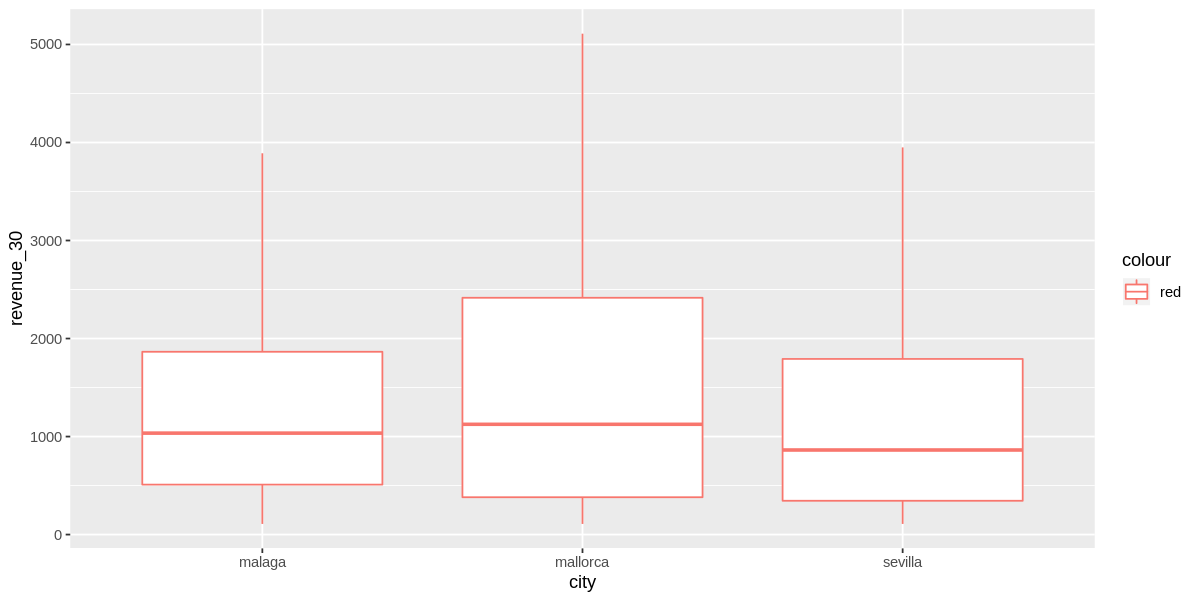

In [11]:
p <- ggplot(listings, aes(city, revenue_30))
p + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T))

## Analysis 1 : comparing cities

#### 1. Find the "average availability over 30 days" of listings per each city

In [12]:
avg_av <- aggregate(listings$availability_30, list(listings$city),mean)
avg_av

Group.1,x
<fct>,<dbl>
malaga,14.88923
mallorca,17.68641
sevilla,16.29727


#### 2. Find the "average revenue over 30 days" of listings per each city

In [13]:
avg_rev <- aggregate(listings$revenue_30,list(listings$city),mean)
avg_rev

Group.1,x
<fct>,<dbl>
malaga,1497.430
mallorca,2853.187
sevilla,1395.862


#### 3. Compare the distribution of estimated availability for the next 30 days of listings per each city

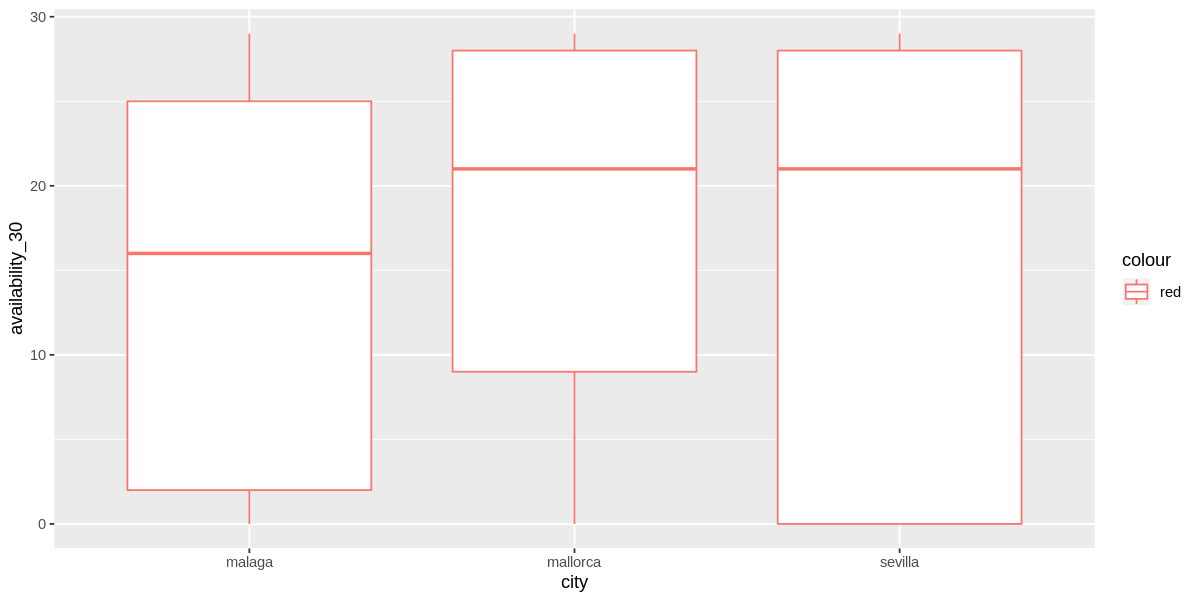

In [14]:
distrib_av <- ggplot(listings, aes(city, availability_30))
distrib_av + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$availability_30, c(0.1, 0.9), na.rm = T))

#### 4. Compare the distribution of estimated revenue for the next 30 days of listings per each city

Warning message:
“Removed 4447 rows containing non-finite values (stat_boxplot).”

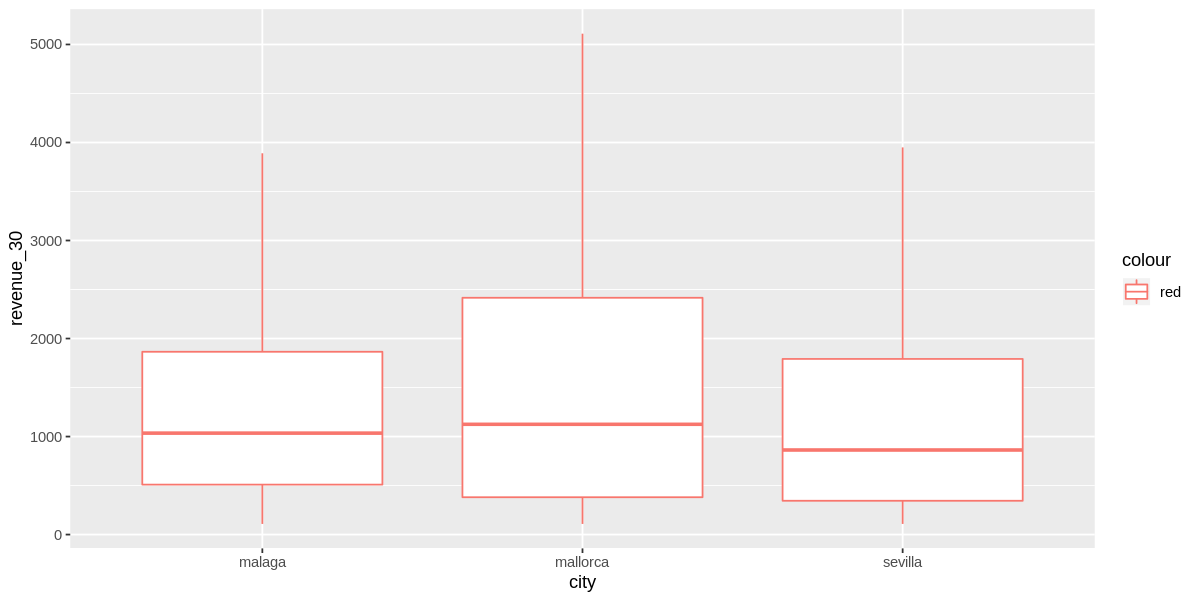

In [15]:
distrib_rv <- ggplot(listings, aes(city, revenue_30))
distrib_rv + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T))

#### 5. Compare the distribution of estimated revenue for the next 30 days of listings per each city & for each house size (# of bedrooms)

Warning message:
“Removed 4447 rows containing non-finite values (stat_boxplot).”

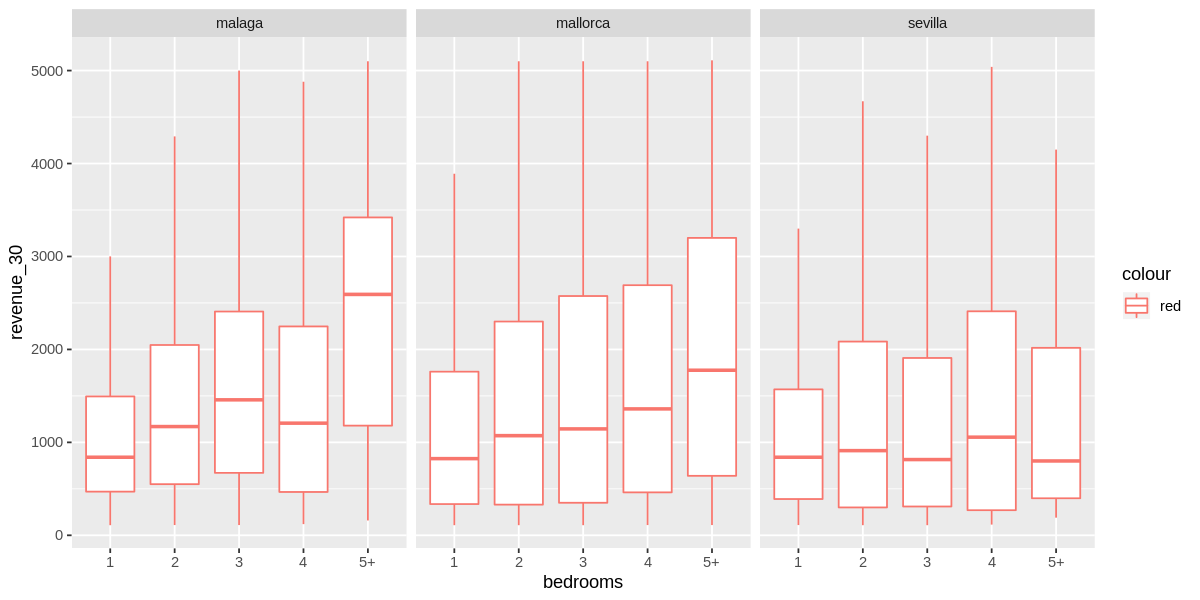

In [16]:
specified <- listings[complete.cases(listings), ]
distrib_rv_hsize <- ggplot(specified, aes(bedrooms, revenue_30))
distrib_rv_hsize + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T)) + 
    facet_wrap(~ city)

#### 6. Compare the distribution of estimated revenue for the next 30 days of listings per each city  & for each room type (room_type)

Warning message:
“Removed 4447 rows containing non-finite values (stat_boxplot).”

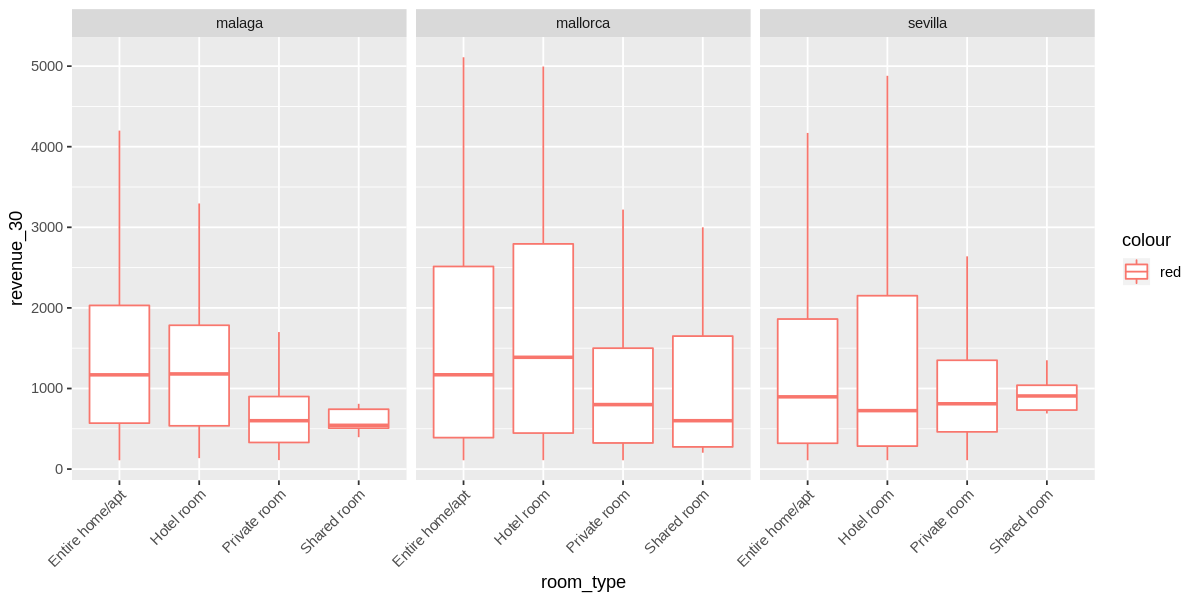

In [17]:
distrib_rv_hsize <- ggplot(listings, aes(room_type, revenue_30))
distrib_rv_hsize + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$revenue_30, c(0.1, 0.9), na.rm = T)) + 
    facet_wrap(~ city)+ 
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Analysis 2 : Deep Dive in one City Analysis

### Functions

#### Proportion of each room type

In [18]:
aggregated_room_types <- function(selected_city){
      listings %>%
      filter(city == selected_city) %>%
      group_by(room_type) %>%
      summarise(nb_rooms = n()) %>%
      mutate(freq = nb_rooms / sum(nb_rooms))
}

#### Proportion of each house size (# of bedroom)

In [19]:
aggregated_house_size <- function(selected_city){ 
    proportion <- listings %>%
    filter(city == selected_city) %>%
    group_by(bedrooms) %>%
    summarise(houze_size = n()) %>%
    mutate(freq = houze_size / sum(houze_size))
    
    # Removing NA
    proportion[complete.cases(proportion), ]
}

#### Proportion of each neighborhood

In [20]:
aggregated_neighborhood <- function(selected_city){ 
    proportion <- listings %>%
    filter(city == selected_city) %>%
    group_by(neighbourhood_cleansed) %>%
    summarise(ngbh = n()) %>%
    mutate(freq = ngbh / sum(ngbh))
    
    # Removing NA
    proportion[complete.cases(proportion), ]
}


####  Average availability over the next 30 days for each room type / house size / neighborhood

In [21]:
aggregated_availability <- function(selected_city){ 
    avg_availability <- listings %>%
    filter(city == selected_city) %>%
    group_by(room_type,bedrooms,neighbourhood_cleansed) %>%
    summarise(mean_availability_30 = mean(availability_30))

    # Removing NA
    avg_availability[complete.cases(avg_availability), ]
}

#### Average revenue over the next 30 days for each room type / house size / neighborhood

In [22]:
aggregated_revenue <- function(selected_city){ 
    avg_revenue <- listings %>%
    filter(city == selected_city) %>%
    group_by(room_type,bedrooms,neighbourhood_cleansed) %>%
    summarise(mean_revenue_30 = mean(revenue_30))

    # Removing NA
    avg_revenue[complete.cases(avg_revenue), ]
}

####  Distribution of availability over the next 30 days for each room type / house size / neighborhood

In [23]:
availability_plotting <- function(selected_city){
    specified <- listings[complete.cases(listings), ] %>%
      filter(city == selected_city)
    
    q <- ggplot(specified, aes(bedrooms, availability_30))
    q+stat_summary(fun.y="mean", geom="point")+
    facet_grid(room_type~neighbourhood_cleansed)+
    theme(strip.text.x = element_text(angle = 90), strip.text.y = element_text(angle = 0))
}

####  Distribution of revenue over the next 30 days for each room type / house size / neighborhood

In [24]:
revenue_plotting <- function(selected_city){
    specified <- listings[complete.cases(listings), ] %>%
      filter(city == selected_city)
    
    q <- ggplot(specified, aes(bedrooms, revenue_30))
    q+stat_summary(fun.y="mean", geom="point")+
    facet_grid(room_type~neighbourhood_cleansed)+
    theme(strip.text.x = element_text(angle = 90), strip.text.y = element_text(angle = 0))
    
}

### A. Malaga

In [25]:
selected_city <- 'malaga'
selected_city

[1] "malaga"

#### 1. What is the proportion of each room type?

In [26]:
aggregated_room_types(selected_city)

room_type,nb_rooms,freq
<fct>,<int>,<dbl>
Entire home/apt,3862,0.835569018
Hotel room,36,0.007788836
Private room,714,0.154478581
Shared room,10,0.002163566


#### 2. What is the proportion of each house size (# of bedroom)?

In [27]:
aggregated_house_size(selected_city)

bedrooms,houze_size,freq
<chr>,<int>,<dbl>
1,2271,0.49134574
2,1307,0.28277802
3,733,0.15858936
4,212,0.04586759
5+,99,0.02141930


#### 3. What is the proportion of each neighborhood?

In [28]:
aggregated_neighborhood(selected_city)

neighbourhood_cleansed,ngbh,freq
<fct>,<int>,<dbl>
Bailen-Miraflores,127,0.027477283
Campanillas,15,0.003245348
Carretera de Cadiz,440,0.095196884
Centro,3022,0.653829511
Churriana,75,0.016226742
Ciudad Jardin,44,0.009519688
Cruz De Humilladero,224,0.048463868
Este,535,0.115750757
Palma-Palmilla,29,0.006274340


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [29]:
aggregated_availability(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Bailen-Miraflores,15.057143
Entire home/apt,1,Campanillas,15.000000
Entire home/apt,1,Carretera de Cadiz,12.318841
Entire home/apt,1,Centro,15.211039
Entire home/apt,1,Churriana,16.416667
Entire home/apt,1,Ciudad Jardin,9.125000
Entire home/apt,1,Cruz De Humilladero,18.909091
Entire home/apt,1,Este,12.534722
Entire home/apt,1,Palma-Palmilla,7.000000


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [30]:
aggregated_revenue(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Bailen-Miraflores,807.3429
Entire home/apt,1,Campanillas,700.0000
Entire home/apt,1,Carretera de Cadiz,1252.6812
Entire home/apt,1,Centro,1336.2979
Entire home/apt,1,Churriana,1127.4167
Entire home/apt,1,Ciudad Jardin,1254.8750
Entire home/apt,1,Cruz De Humilladero,853.7727
Entire home/apt,1,Este,1314.4306
Entire home/apt,1,Palma-Palmilla,1388.0000


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

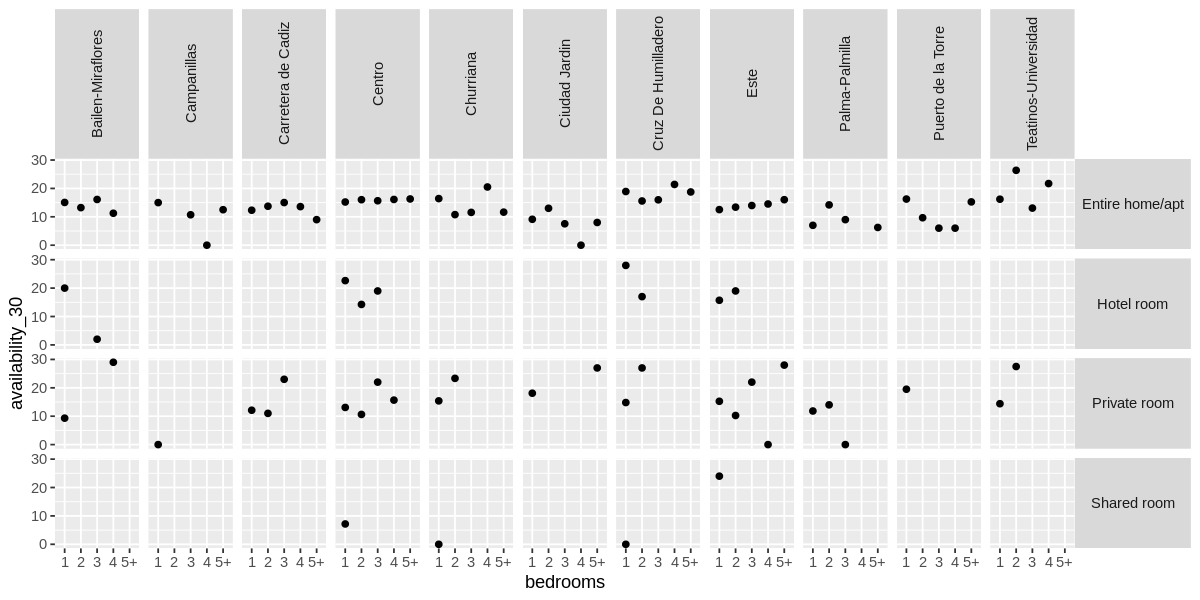

In [31]:
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

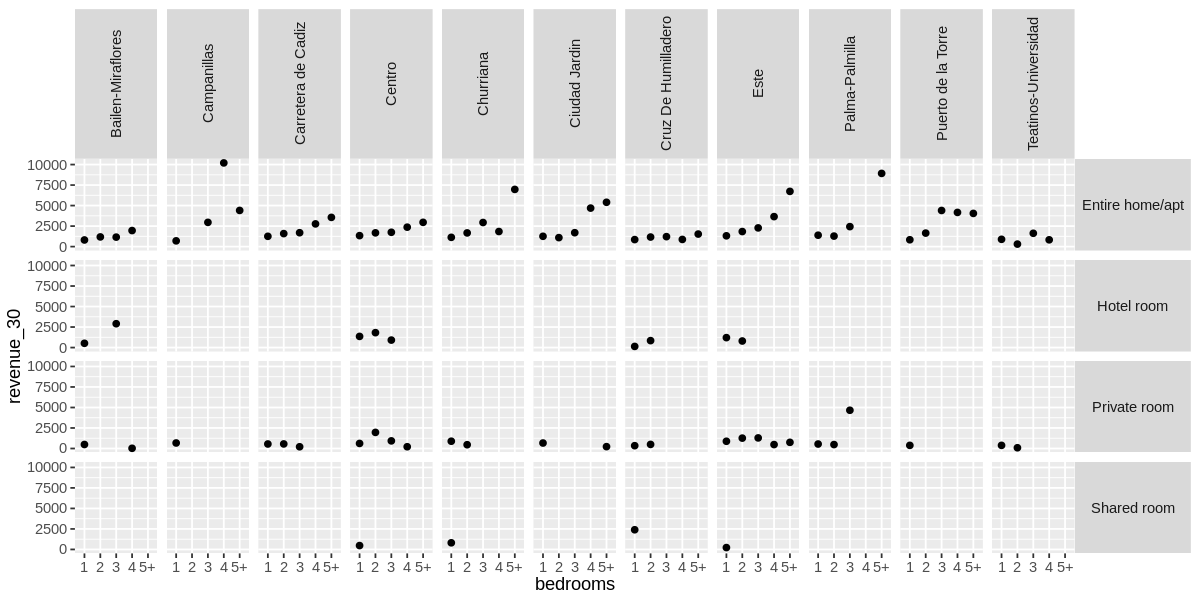

In [32]:
revenue_plotting(selected_city)

### B. Mallorca

In [33]:
selected_city <- 'mallorca'
selected_city

[1] "mallorca"

#### 1. What is the proportion of each room type?

In [34]:
aggregated_room_types(selected_city)

room_type,nb_rooms,freq
<fct>,<int>,<dbl>
Entire home/apt,11741,0.9055221348
Hotel room,160,0.0123399661
Private room,1056,0.0814437760
Shared room,9,0.0006941231


#### 2. What is the proportion of each house size (# of bedroom)?

In [35]:
aggregated_house_size(selected_city)

bedrooms,houze_size,freq
<chr>,<int>,<dbl>
1,2305,0.1777726
2,2496,0.1925035
3,4053,0.3125868
4,2591,0.1998303
5+,1521,0.1173068


#### 3. What is the proportion of each neighborhood?

In [36]:
aggregated_neighborhood(selected_city)

neighbourhood_cleansed,ngbh,freq
<fct>,<int>,<dbl>
Alaró,77,0.0059386087
Alcúdia,1283,0.0989511029
Algaida,101,0.0077896036
Andratx,188,0.0144994601
Ariany,53,0.0040876138
Artà,276,0.0212864415
Banyalbufar,44,0.0033934907
Binissalem,68,0.0052444856
Búger,123,0.0094863489


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [37]:
aggregated_availability(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Alaró,22.87500
Entire home/apt,1,Alcúdia,21.19481
Entire home/apt,1,Algaida,16.44444
Entire home/apt,1,Andratx,20.40000
Entire home/apt,1,Artà,17.33333
Entire home/apt,1,Banyalbufar,13.66667
Entire home/apt,1,Binissalem,17.00000
Entire home/apt,1,Búger,7.00000
Entire home/apt,1,Bunyola,11.75000


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [38]:
aggregated_revenue(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Alaró,1822.2500
Entire home/apt,1,Alcúdia,769.4156
Entire home/apt,1,Algaida,1896.8889
Entire home/apt,1,Andratx,1077.0000
Entire home/apt,1,Artà,1286.3333
Entire home/apt,1,Banyalbufar,1745.0000
Entire home/apt,1,Binissalem,1727.5000
Entire home/apt,1,Búger,2102.5000
Entire home/apt,1,Bunyola,1079.5000


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

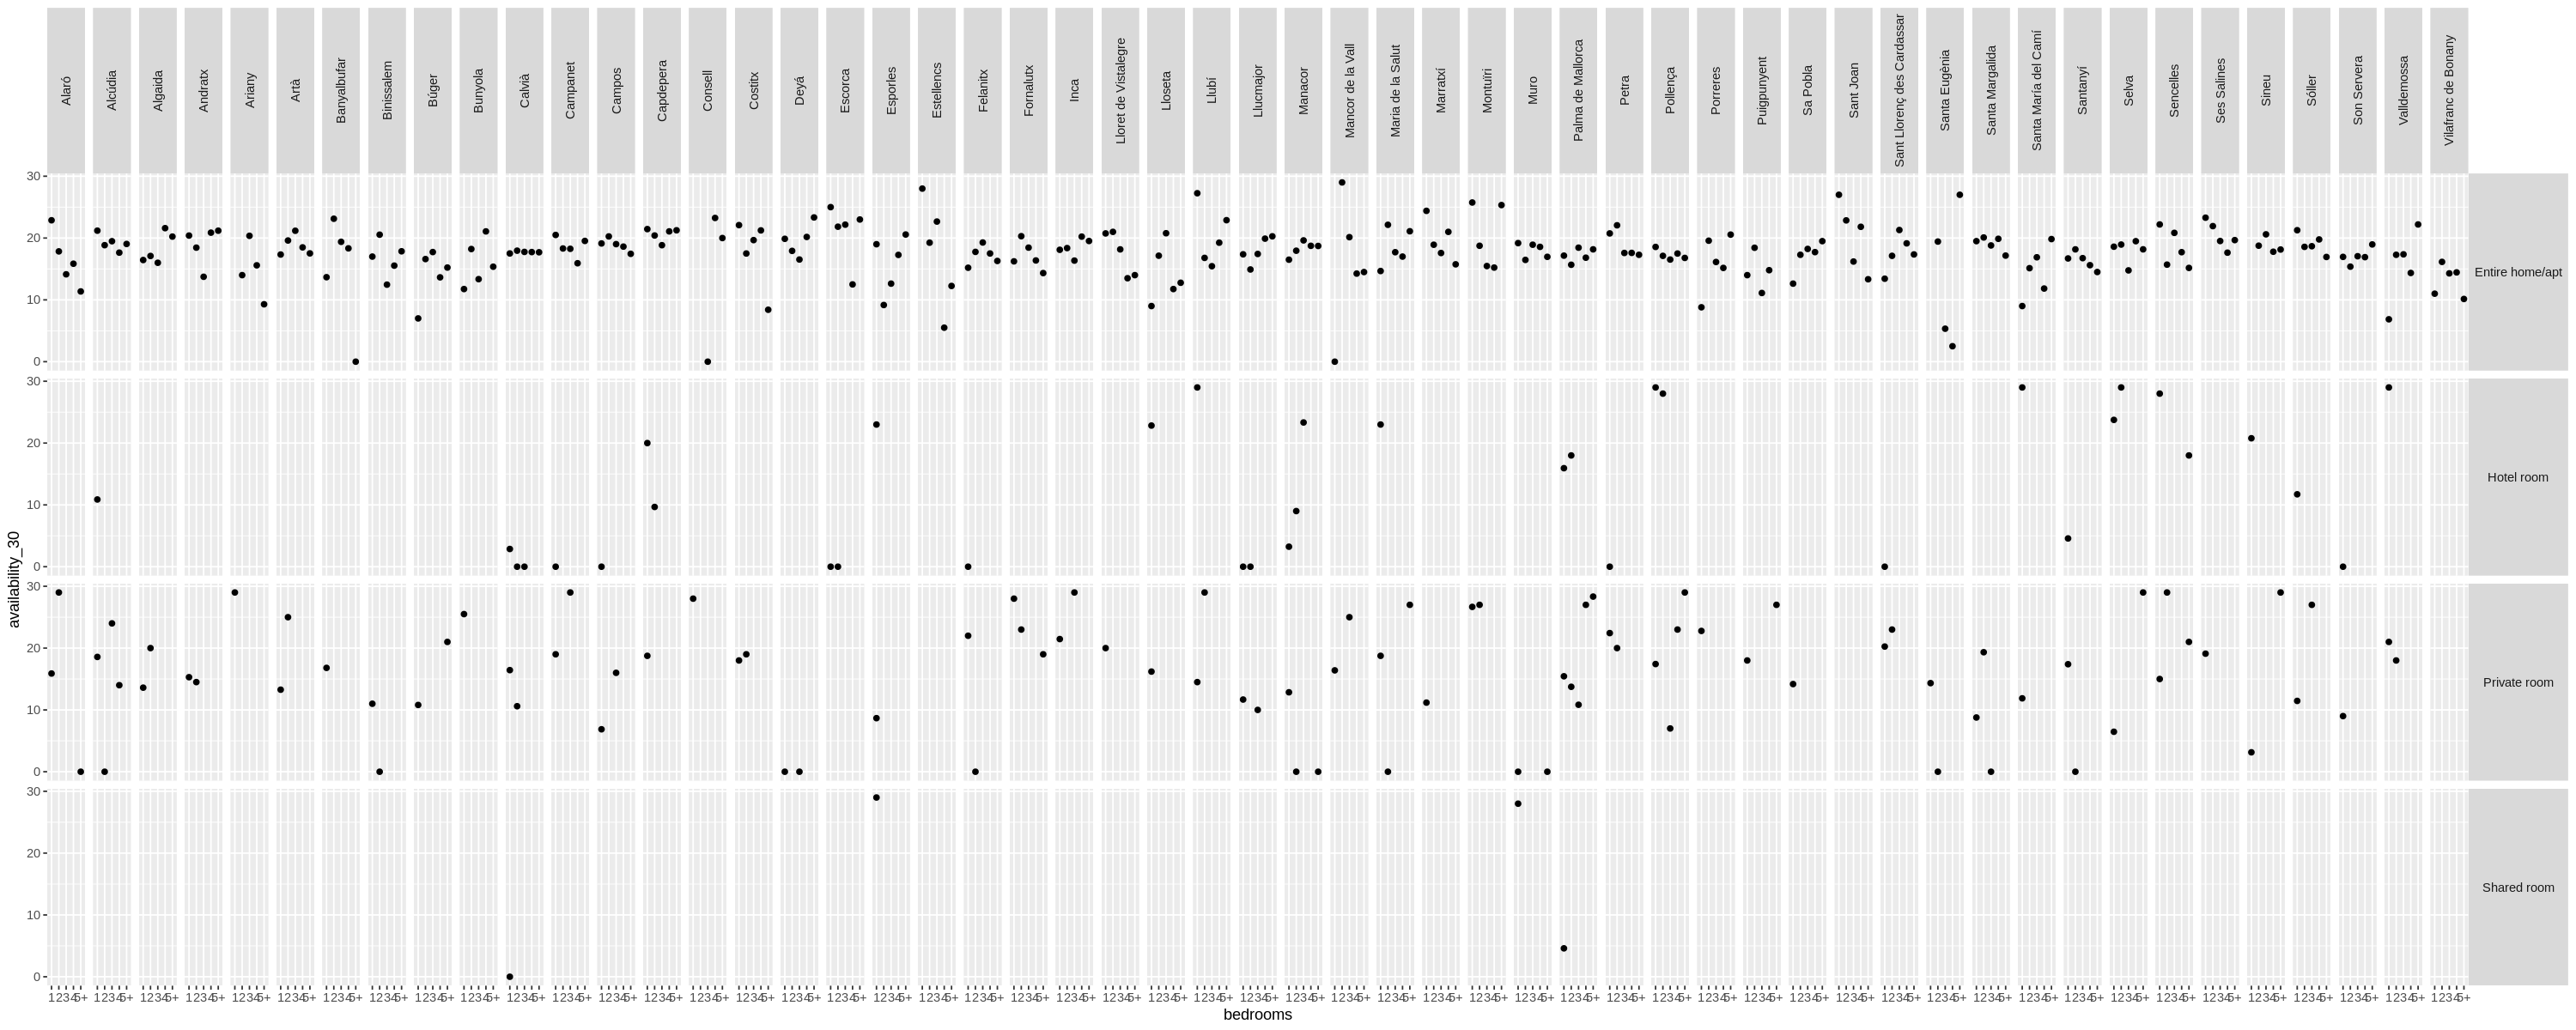

In [39]:
options(repr.plot.width = 25, repr.plot.height = 10)
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

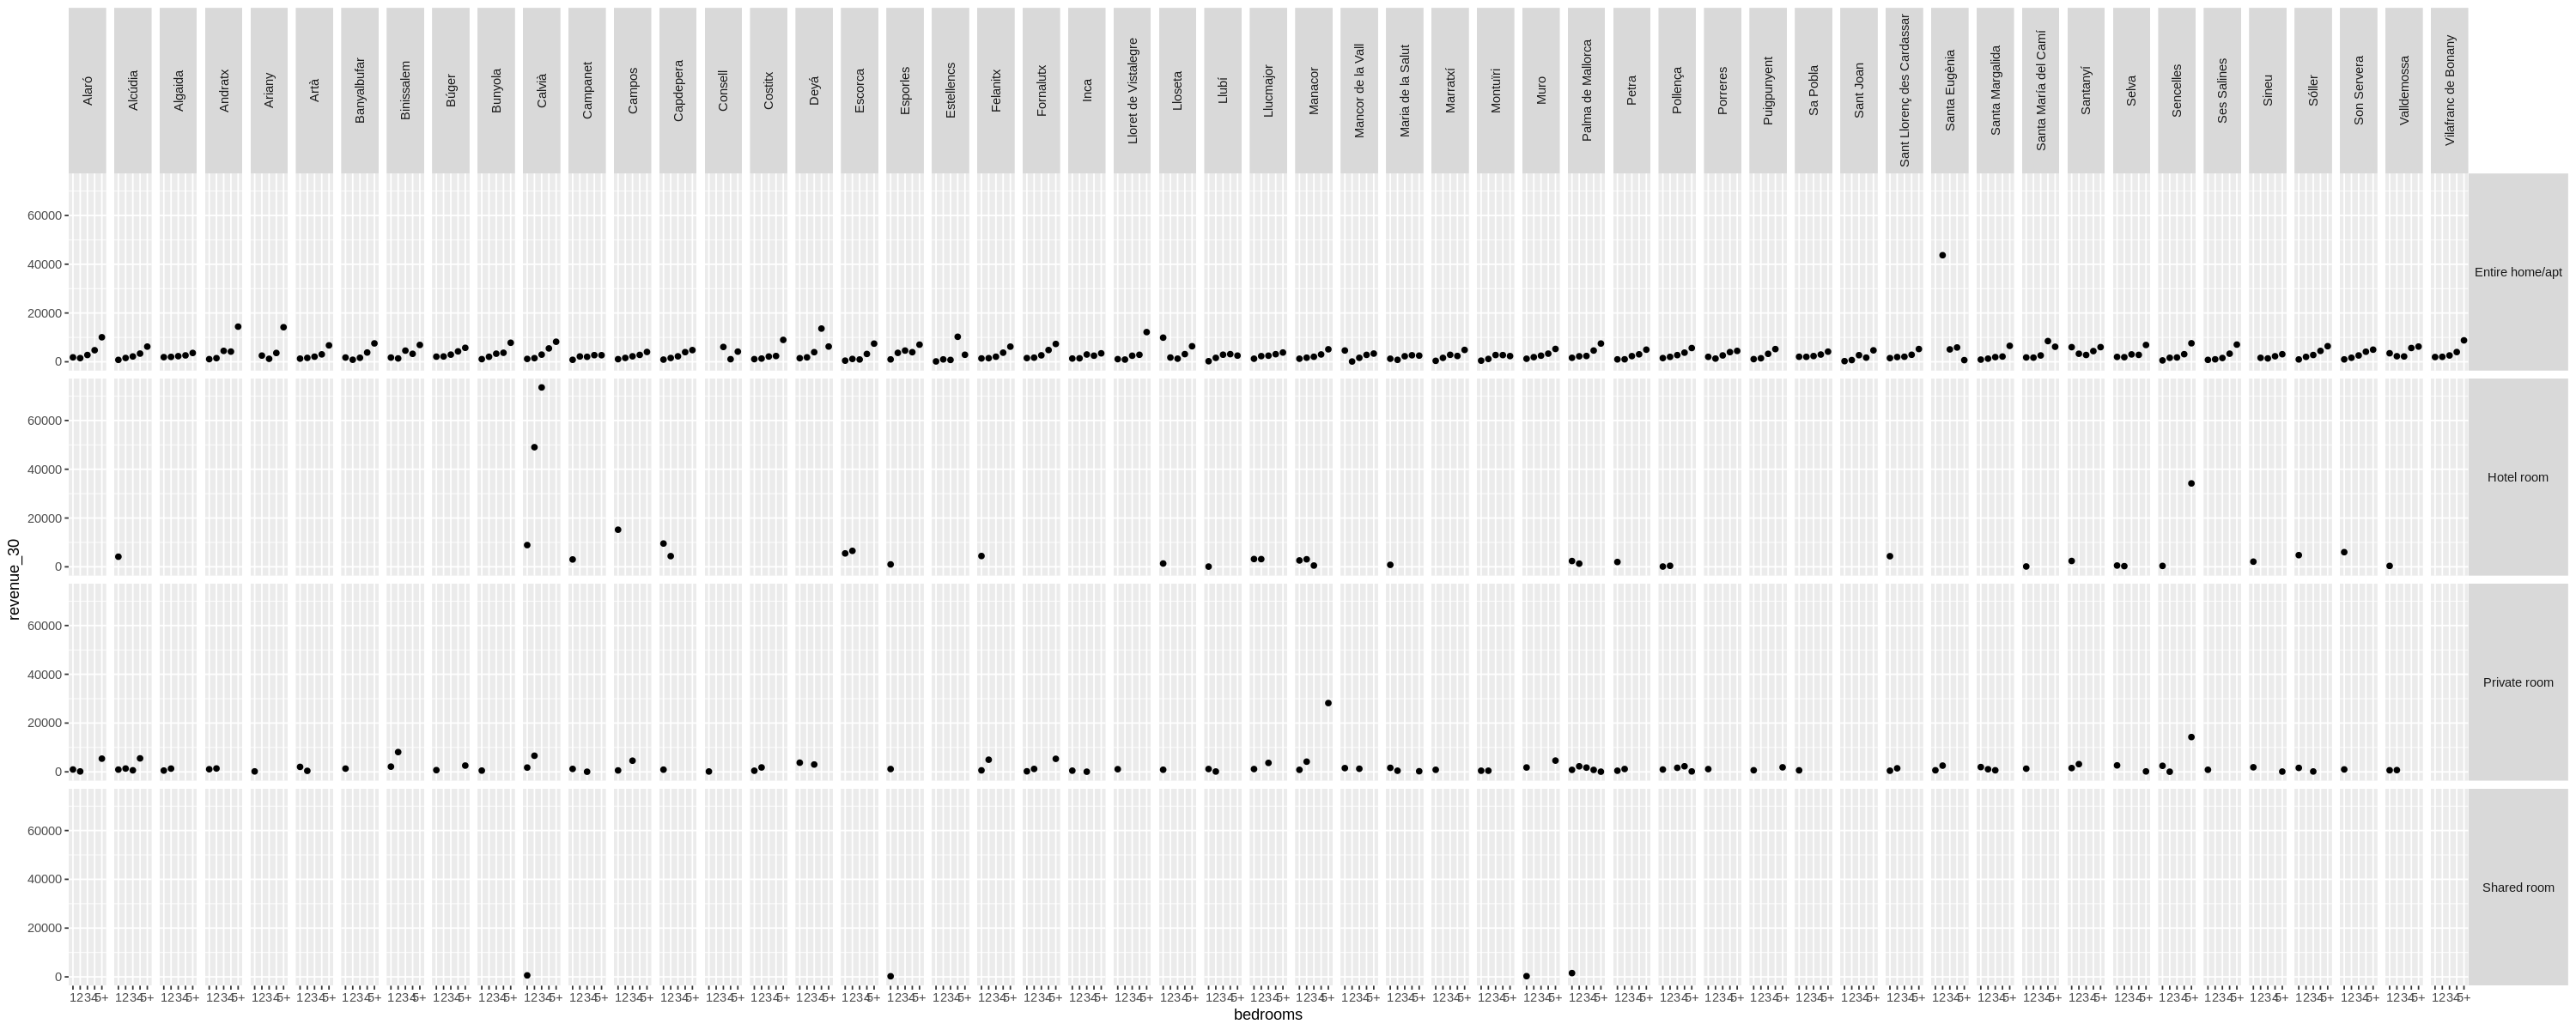

In [40]:
revenue_plotting(selected_city)

### C. Sevilla

In [41]:
selected_city <- 'sevilla'
selected_city

[1] "sevilla"

#### 1. What is the proportion of each room type?

In [42]:
aggregated_room_types(selected_city)

room_type,nb_rooms,freq
<fct>,<int>,<dbl>
Entire home/apt,3652,0.783859197
Hotel room,83,0.017814982
Private room,916,0.196608714
Shared room,8,0.001717107


#### 2. What is the proportion of each house size (# of bedroom)?

In [43]:
aggregated_house_size(selected_city)

bedrooms,houze_size,freq
<chr>,<int>,<dbl>
1,2565,0.55054733
2,1406,0.30178150
3,521,0.11182657
4,111,0.02382486
5+,56,0.01201975


#### 3. What is the proportion of each neighborhood?

In [44]:
aggregated_neighborhood(selected_city)

neighbourhood_cleansed,ngbh,freq
<fct>,<int>,<dbl>
Alfalfa,492,0.1056020605
Amate,4,0.0008585533
an Roque,53,0.0113758317
Arbol Gordo,1,0.0002146383
Arenal,351,0.0753380554
Avda. de la Paz,4,0.0008585533
Bami,4,0.0008585533
Barrio León,14,0.0030049367
Bda. de Pineda,4,0.0008585533


#### 4. What is the average availability over the next 30 days for each room type / house size / neighborhood?

In [45]:
aggregated_availability(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_availability_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Alfalfa,14.15122
Entire home/apt,1,an Roque,20.40000
Entire home/apt,1,Arbol Gordo,0.00000
Entire home/apt,1,Arenal,16.88489
Entire home/apt,1,Bami,23.00000
Entire home/apt,1,Barrio León,19.33333
Entire home/apt,1,Bda. de Pineda,0.00000
Entire home/apt,1,"Carretera de Carmona, María Auxiliadora, Fontanal",3.00000
Entire home/apt,1,Ciudad Jardín,23.00000


#### 5. What is the average revenue over the next 30 days for each room type / house size / neighborhood?

In [46]:
aggregated_revenue(selected_city)

room_type,bedrooms,neighbourhood_cleansed,mean_revenue_30
<fct>,<chr>,<fct>,<dbl>
Entire home/apt,1,Alfalfa,1480.3463
Entire home/apt,1,an Roque,580.6000
Entire home/apt,1,Arbol Gordo,4500.0000
Entire home/apt,1,Arenal,1076.7266
Entire home/apt,1,Bami,441.0000
Entire home/apt,1,Barrio León,499.3333
Entire home/apt,1,Bda. de Pineda,1280.0000
Entire home/apt,1,"Carretera de Carmona, María Auxiliadora, Fontanal",2573.0000
Entire home/apt,1,Ciudad Jardín,385.0000


#### 6. What is the distribution of availability over the next 30 days for each room type/ house size / neighborhood?

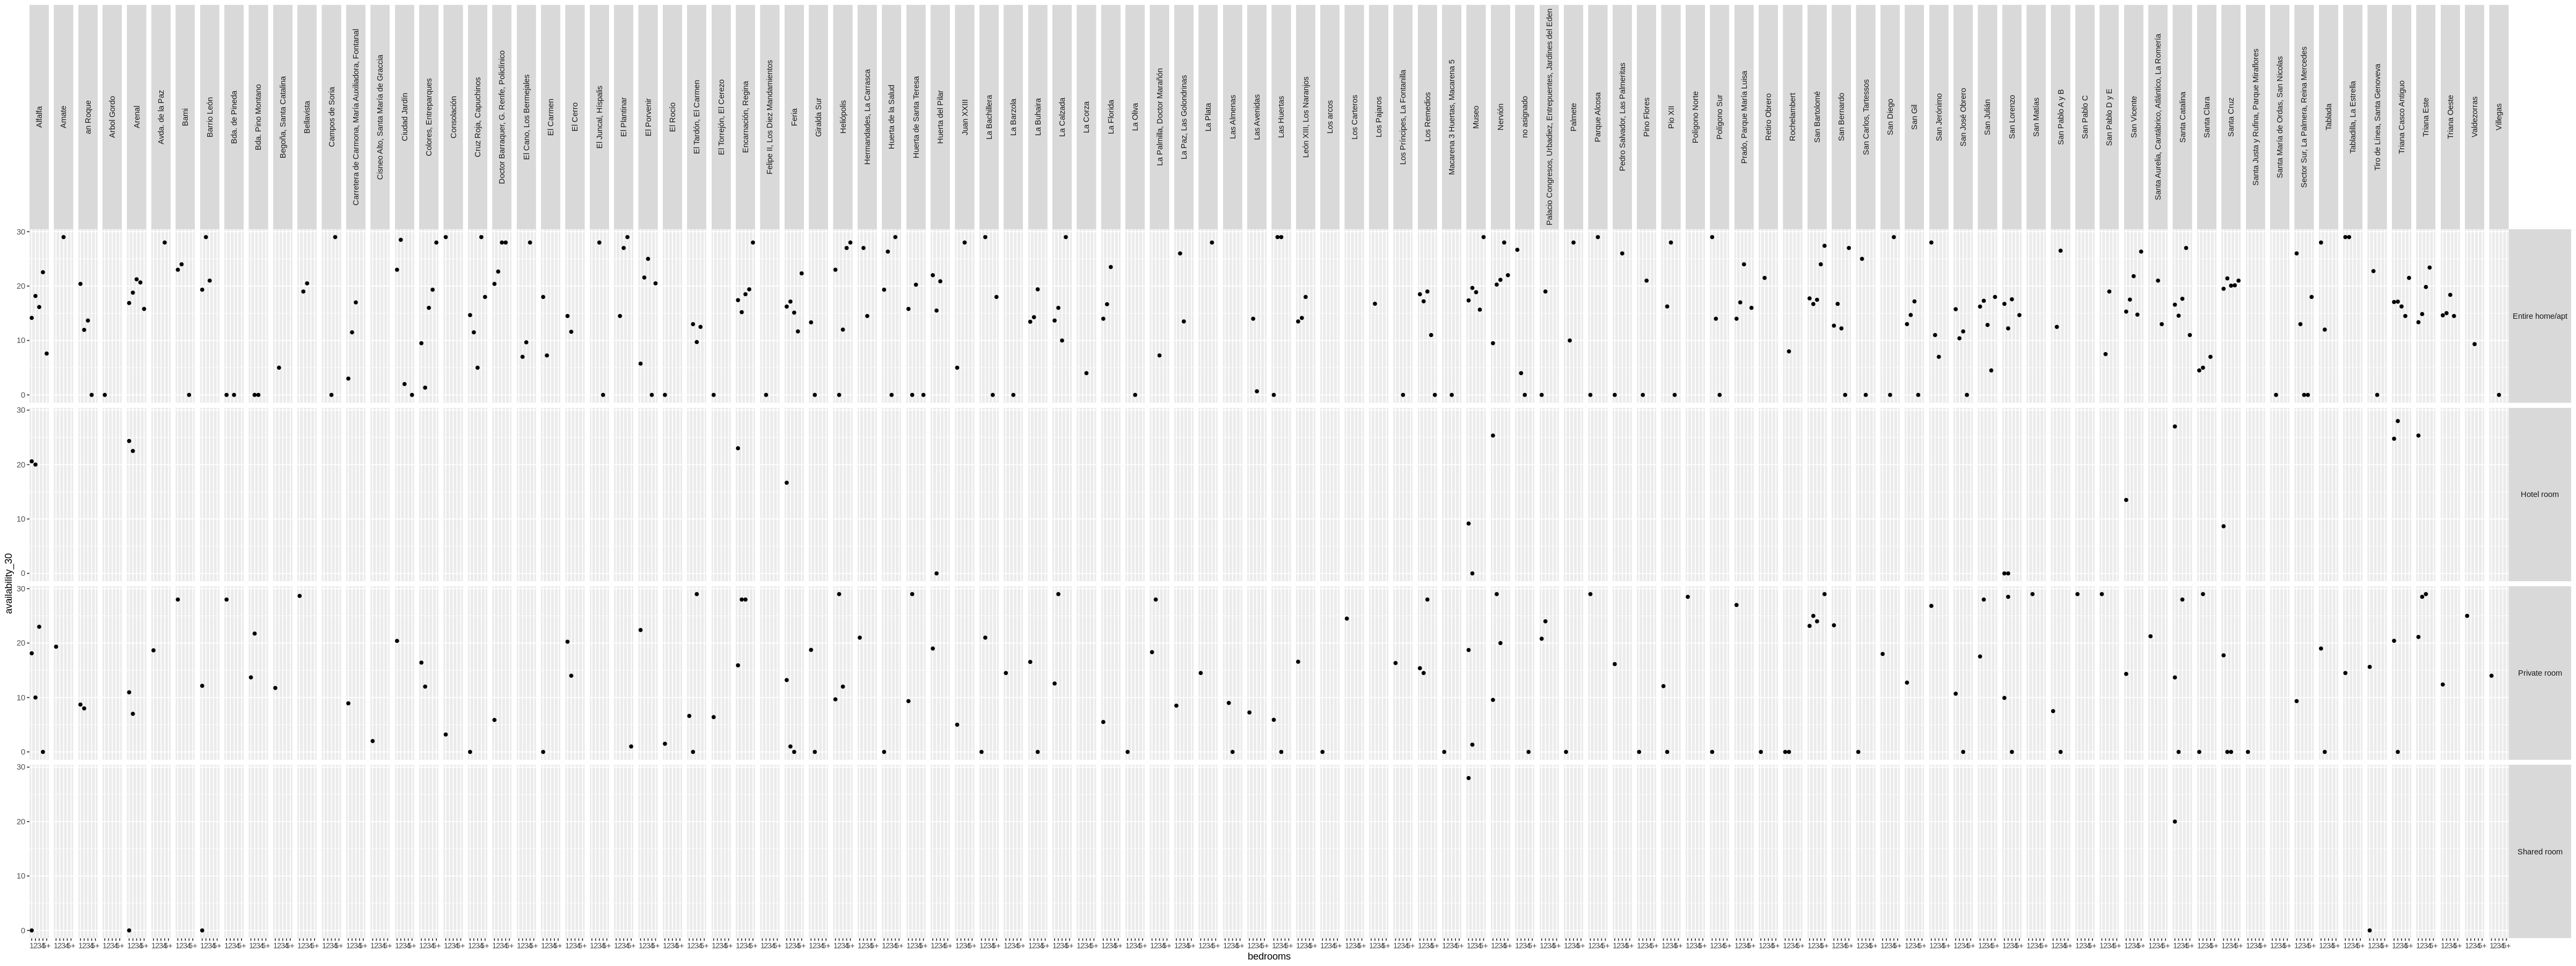

In [47]:
options(repr.plot.width = 40, repr.plot.height = 15)
availability_plotting(selected_city)

#### 7. What is the distribution of revenue over the next 30 days for each room type / house size / neighborhood? 

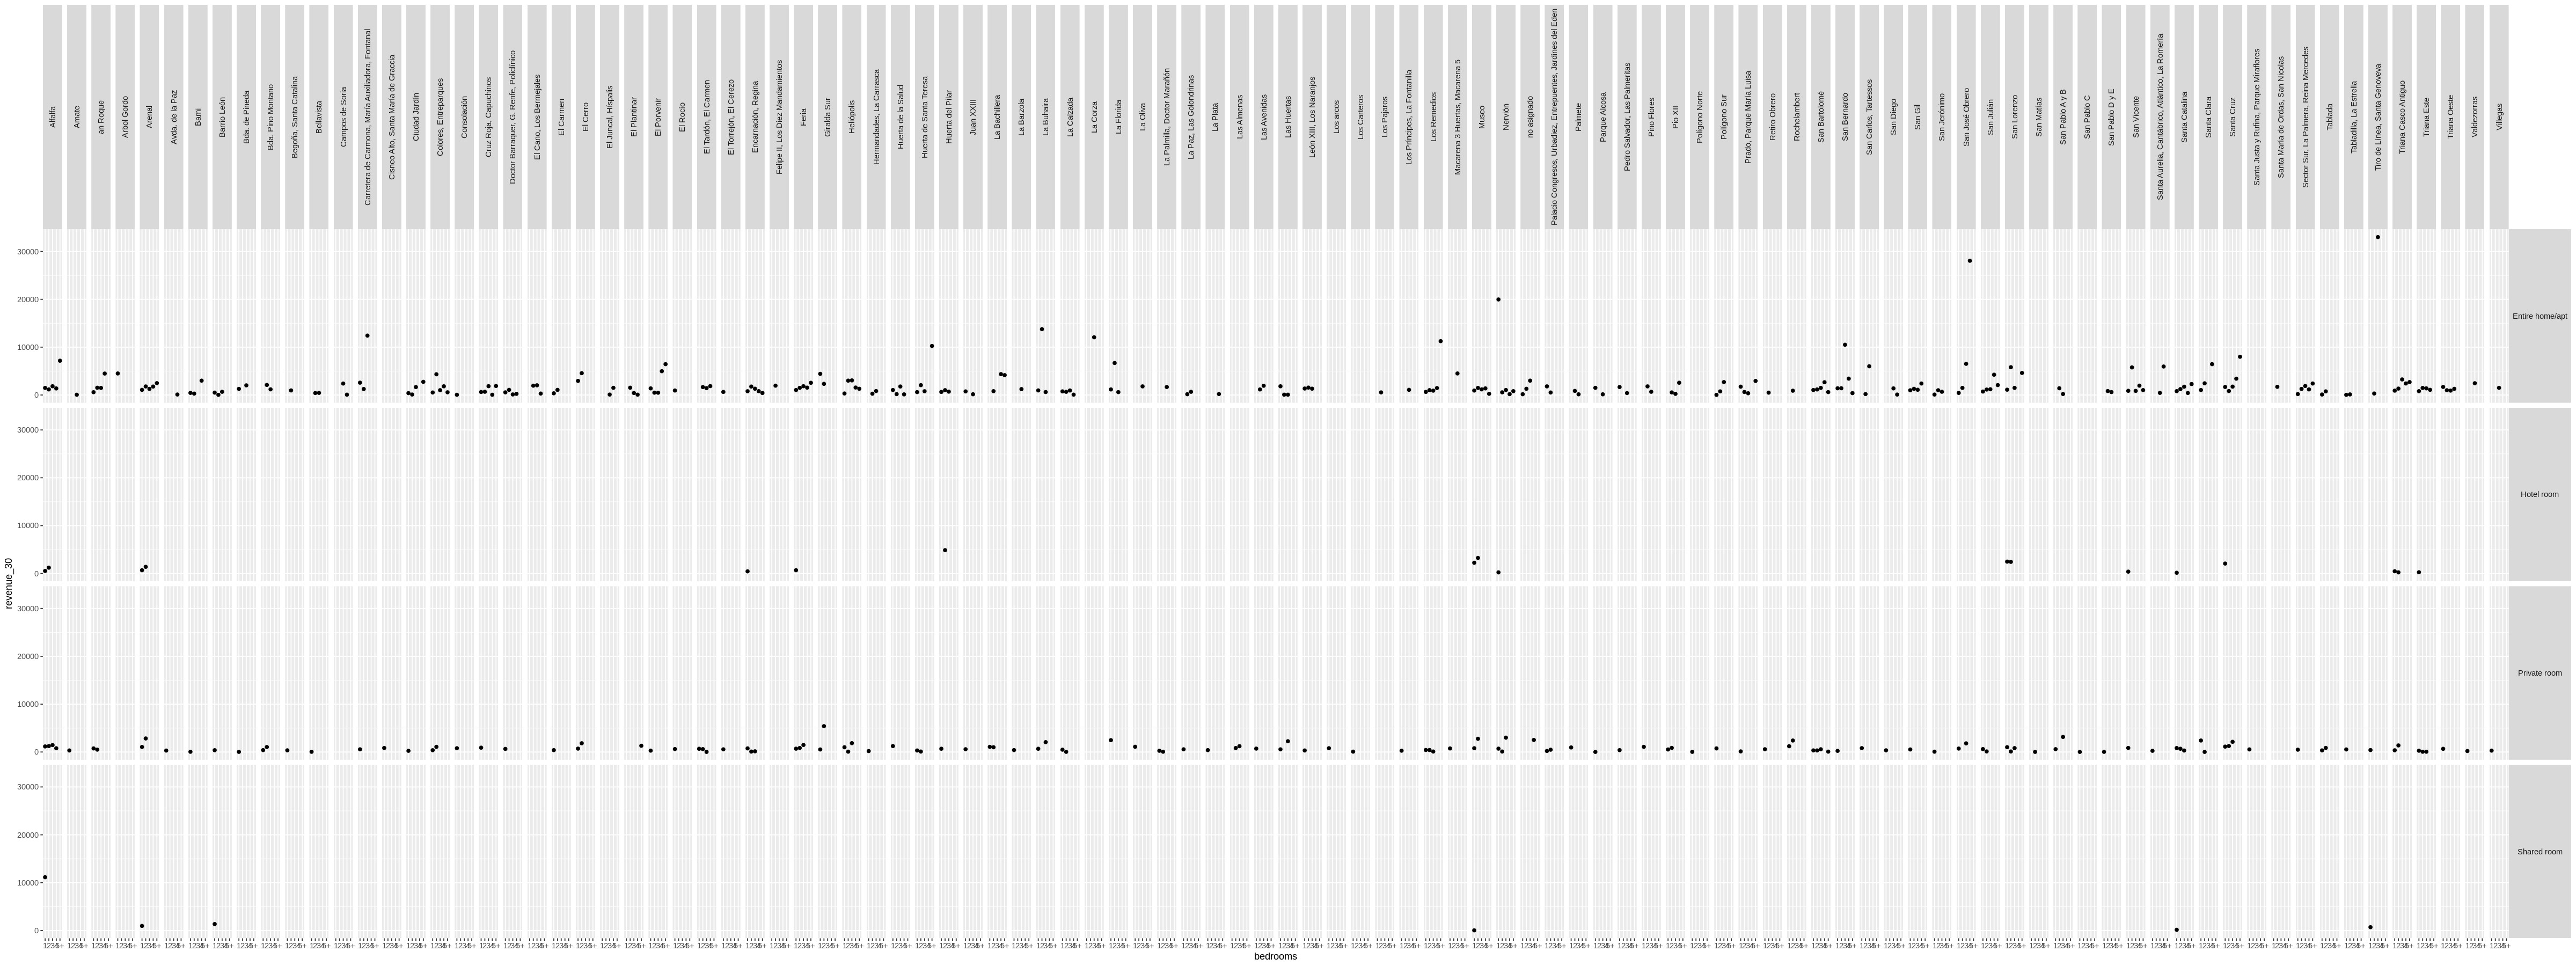

In [48]:
revenue_plotting(selected_city)

## Additional Analysis :
### Compute the break even point 

_Break Event Point_ : the point at which a business starts to make as much money as it has spent on a particular product, activity, etc
The BEP monitors how fast or how much money is required for the invest to make benefits : it is **widely used by managers to interpret the profitability of a product**, in our case : the profitability of the invest.

#### Calculation
$$Break Even Point = {\sum{Fixed Cost} \over Income – VariableCostsPerUnit}.$$

* Fixed costs are costs that are not related to the activity
* Variable costs are costs related to the activity
* Income is the money earned


#### Additionnal Data :
In this particular case : 
* Fixed costs : Price of the Rent
* Variable costs : Electricity
* Income : Revenue over 365 days
Data extracted by this [website](https://www.combien-coute.net/)


|Ville| Sevilla  | Malaga | Majorqua  | 
|--|--|--|--|
|Square Meter| **2516.67 €** | **2842.86 €** | **3483.33 €** |
|Variable Expenses| **126.44 €** | **112.01 €** | **107.92 €**|

#### Consideration : 
For the ease of the data harvesting we consider that:
* the square meter price is even in each city
* the average size for a bedroom is 10 square meter
* each house as a lounge room of a size : ```1,5*number of room+7,5```
* the price of the electricity is the same for every house

### Bonus :
For each city :
- [ ] Fetch the price of squaremeter in each city : fixed cost
- [ ] Fetch the price of the electricity and water in each city : variable cost 
- [ ] Compute the breakeven point in days and in € : Fixed Cost / (Income-variable cost)

### For the 3 cities

In [49]:
cities <- c("sevilla","malaga", "mallorca")
square_meter <- c(2516.67,2842.86,3483.33)
charges <- c(126.44,112.01,107.92)

In [50]:
for(i in 1:length(cities)){
    city <- cities[i]
    bool_index <- listings_full$city==city
    # Creating fixed costs column 
    fixed_cost<-(square_meter[i]*(listings_full[bool_index,]$bedrooms* 10 + (1.5*listings_full[bool_index,]$bedrooms+8.5)))
    listings_full[bool_index, 'fixed_cost'] <- fixed_cost
    # Creating var costs column
    listings_full[bool_index, 'var_cost'] <- ((charges[i]/31) * (365-as.integer(listings_full[bool_index, ]$availability_365)))
    # Break Even Point in Year
    listings_full[bool_index,'bep_year'] <- listings_full[bool_index,]$fixed_cost/(listings_full[bool_index,]$revenue_365-listings_full[bool_index,]$var_cost)
    # Break Even Point in Turnover
    listings_full[bool_index,'bep_turnover'] <- listings_full[bool_index,]$fixed_cost/((listings_full[bool_index,]$revenue_365-listings_full[bool_index,]$var_cost)/listings_full[bool_index,]$revenue_365)
}

In [51]:
avg_bep_year <- aggregate(listings_full$bep_year,list(listings_full$city),mean)
avg_bep_year

Group.1,x
<fct>,<dbl>
malaga,64.13687
mallorca,84.00211
sevilla,83.89228


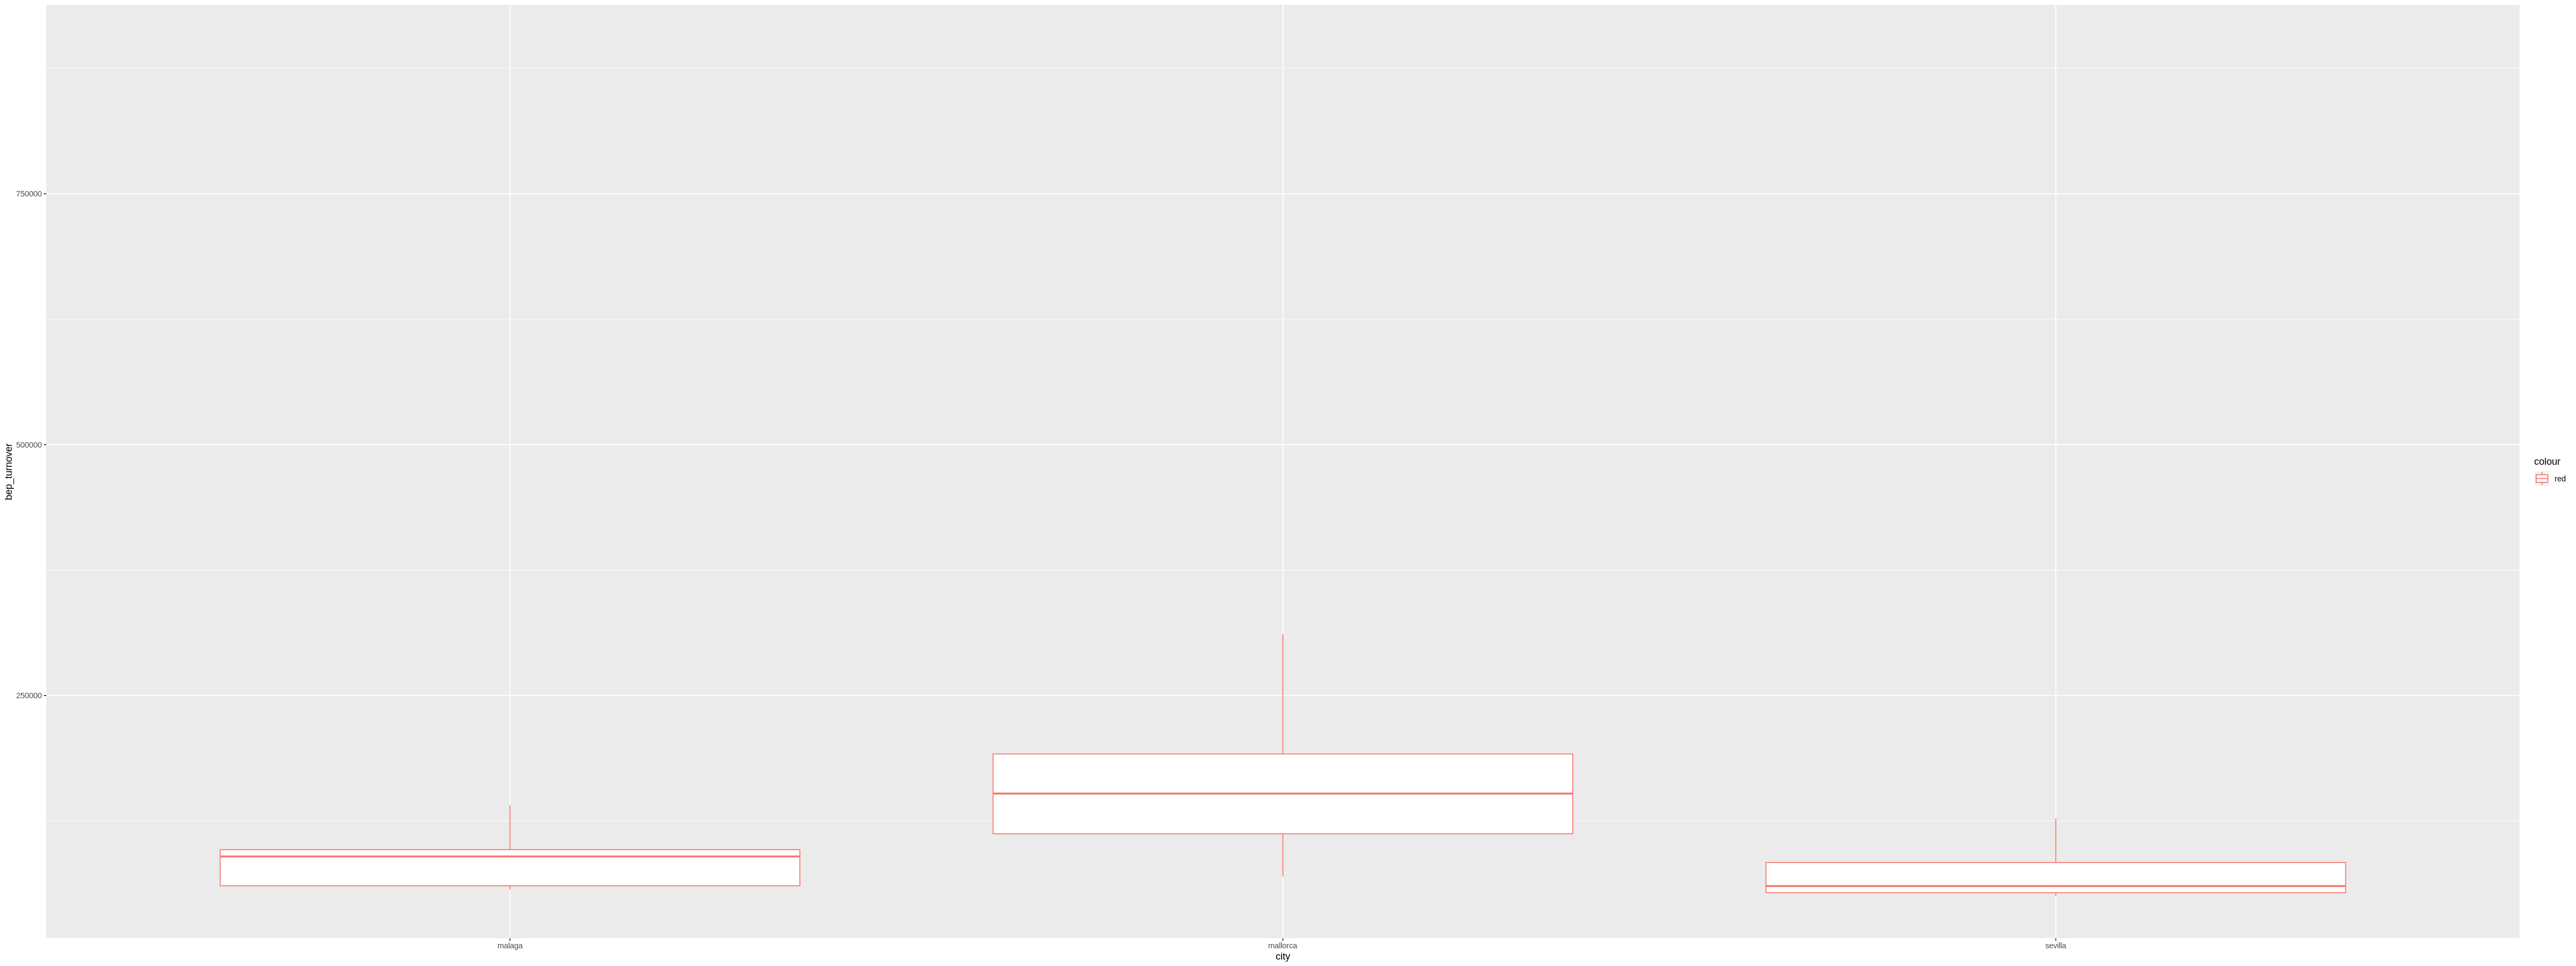

In [52]:
distrib_bep_year <- ggplot(listings_full, aes(city, bep_turnover))
distrib_bep_year + geom_boxplot(aes(colour = "red"), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$bep_turnover, c(0.1, 0.9), na.rm = T))

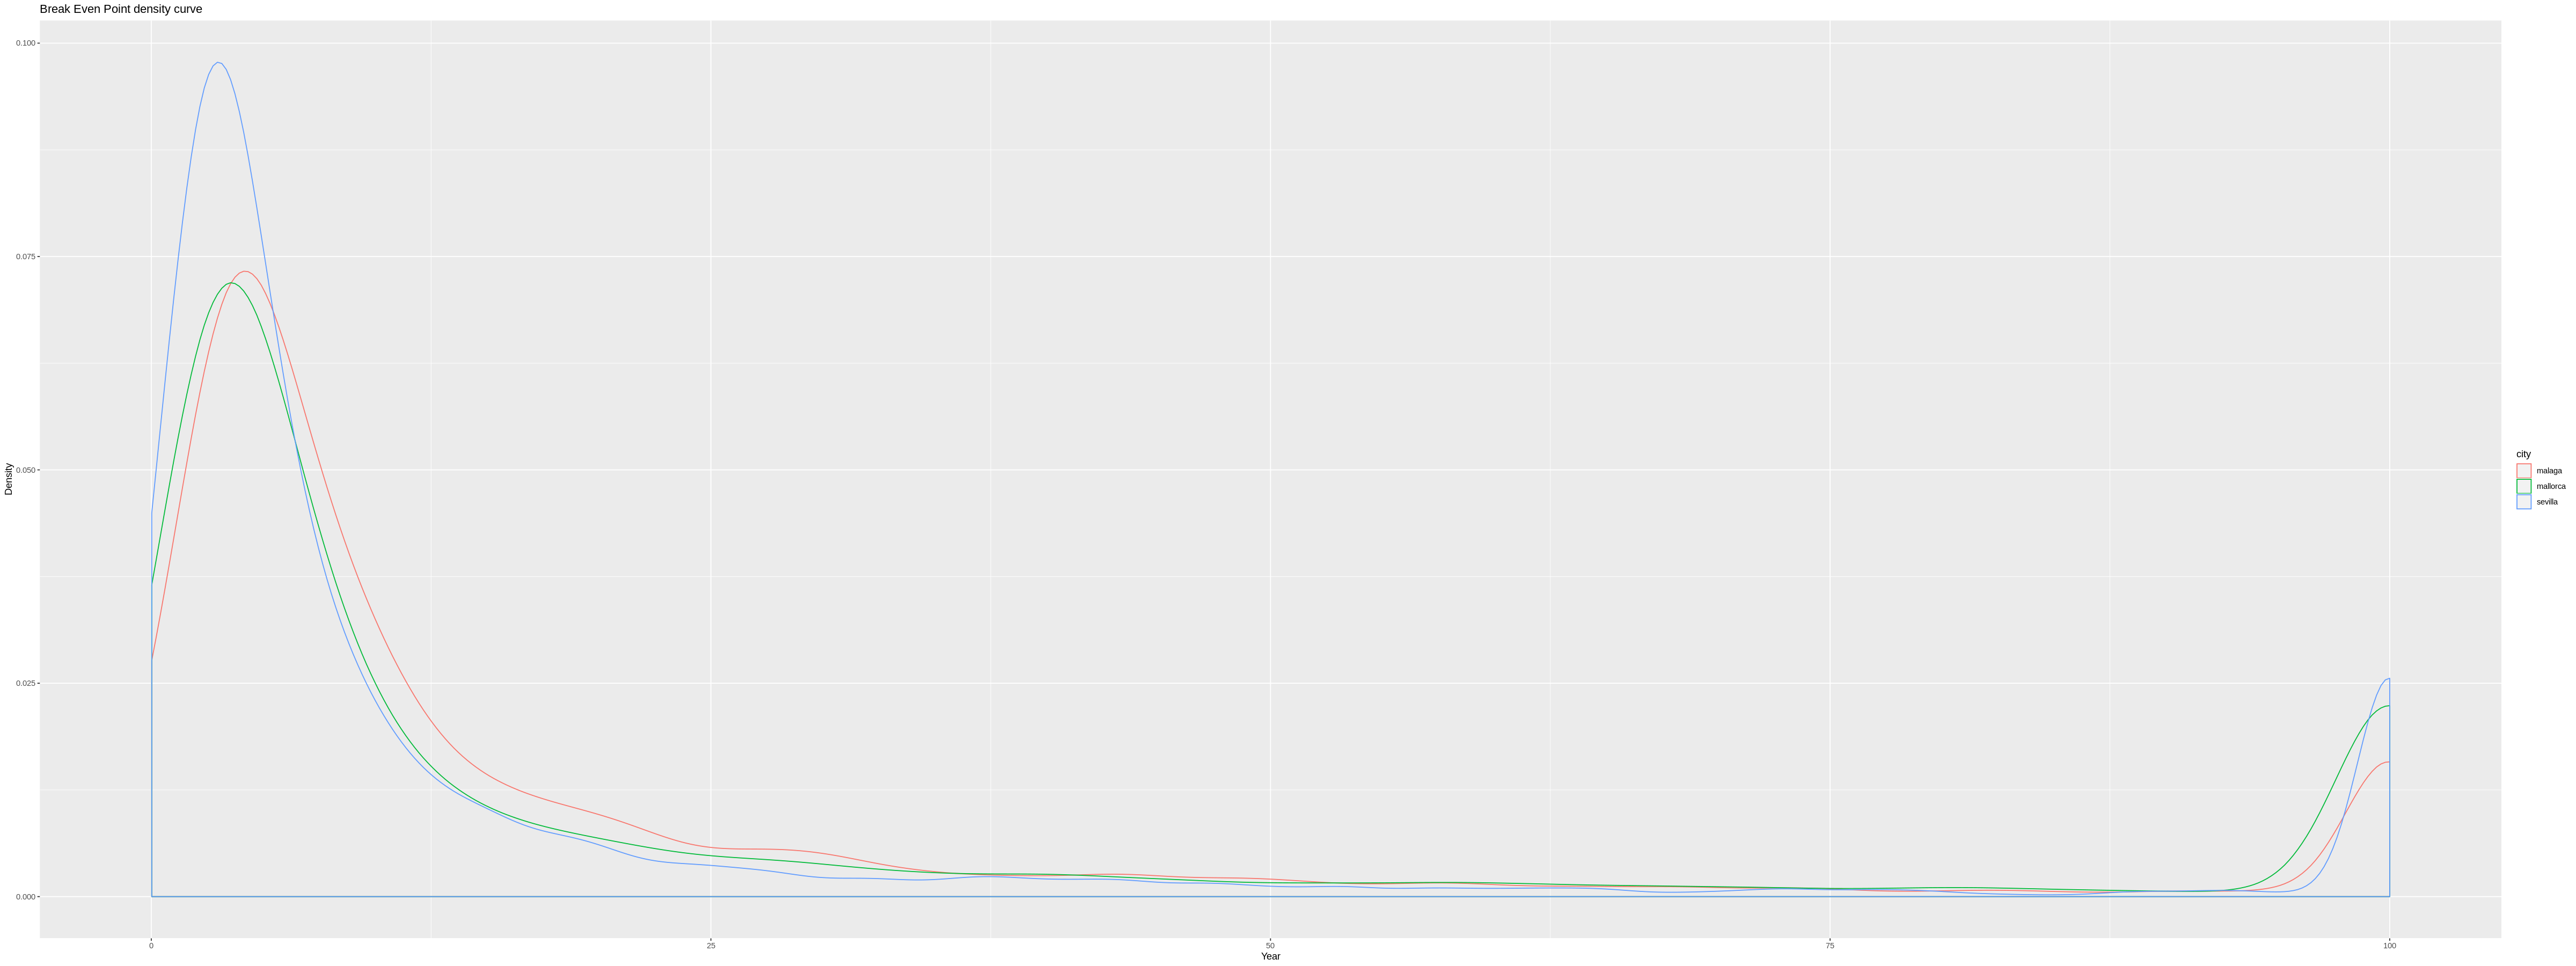

In [53]:
# To smooth the Break Even Point in Year
listings_full$bep_year[listings_full$bep_year>100] <- 100
p<- ggplot(listings_full, aes(x=bep_year, color=city)) +
  geom_density(size=0.5)+
  labs(title="Break Even Point density curve",x="Year", y = "Density")
p

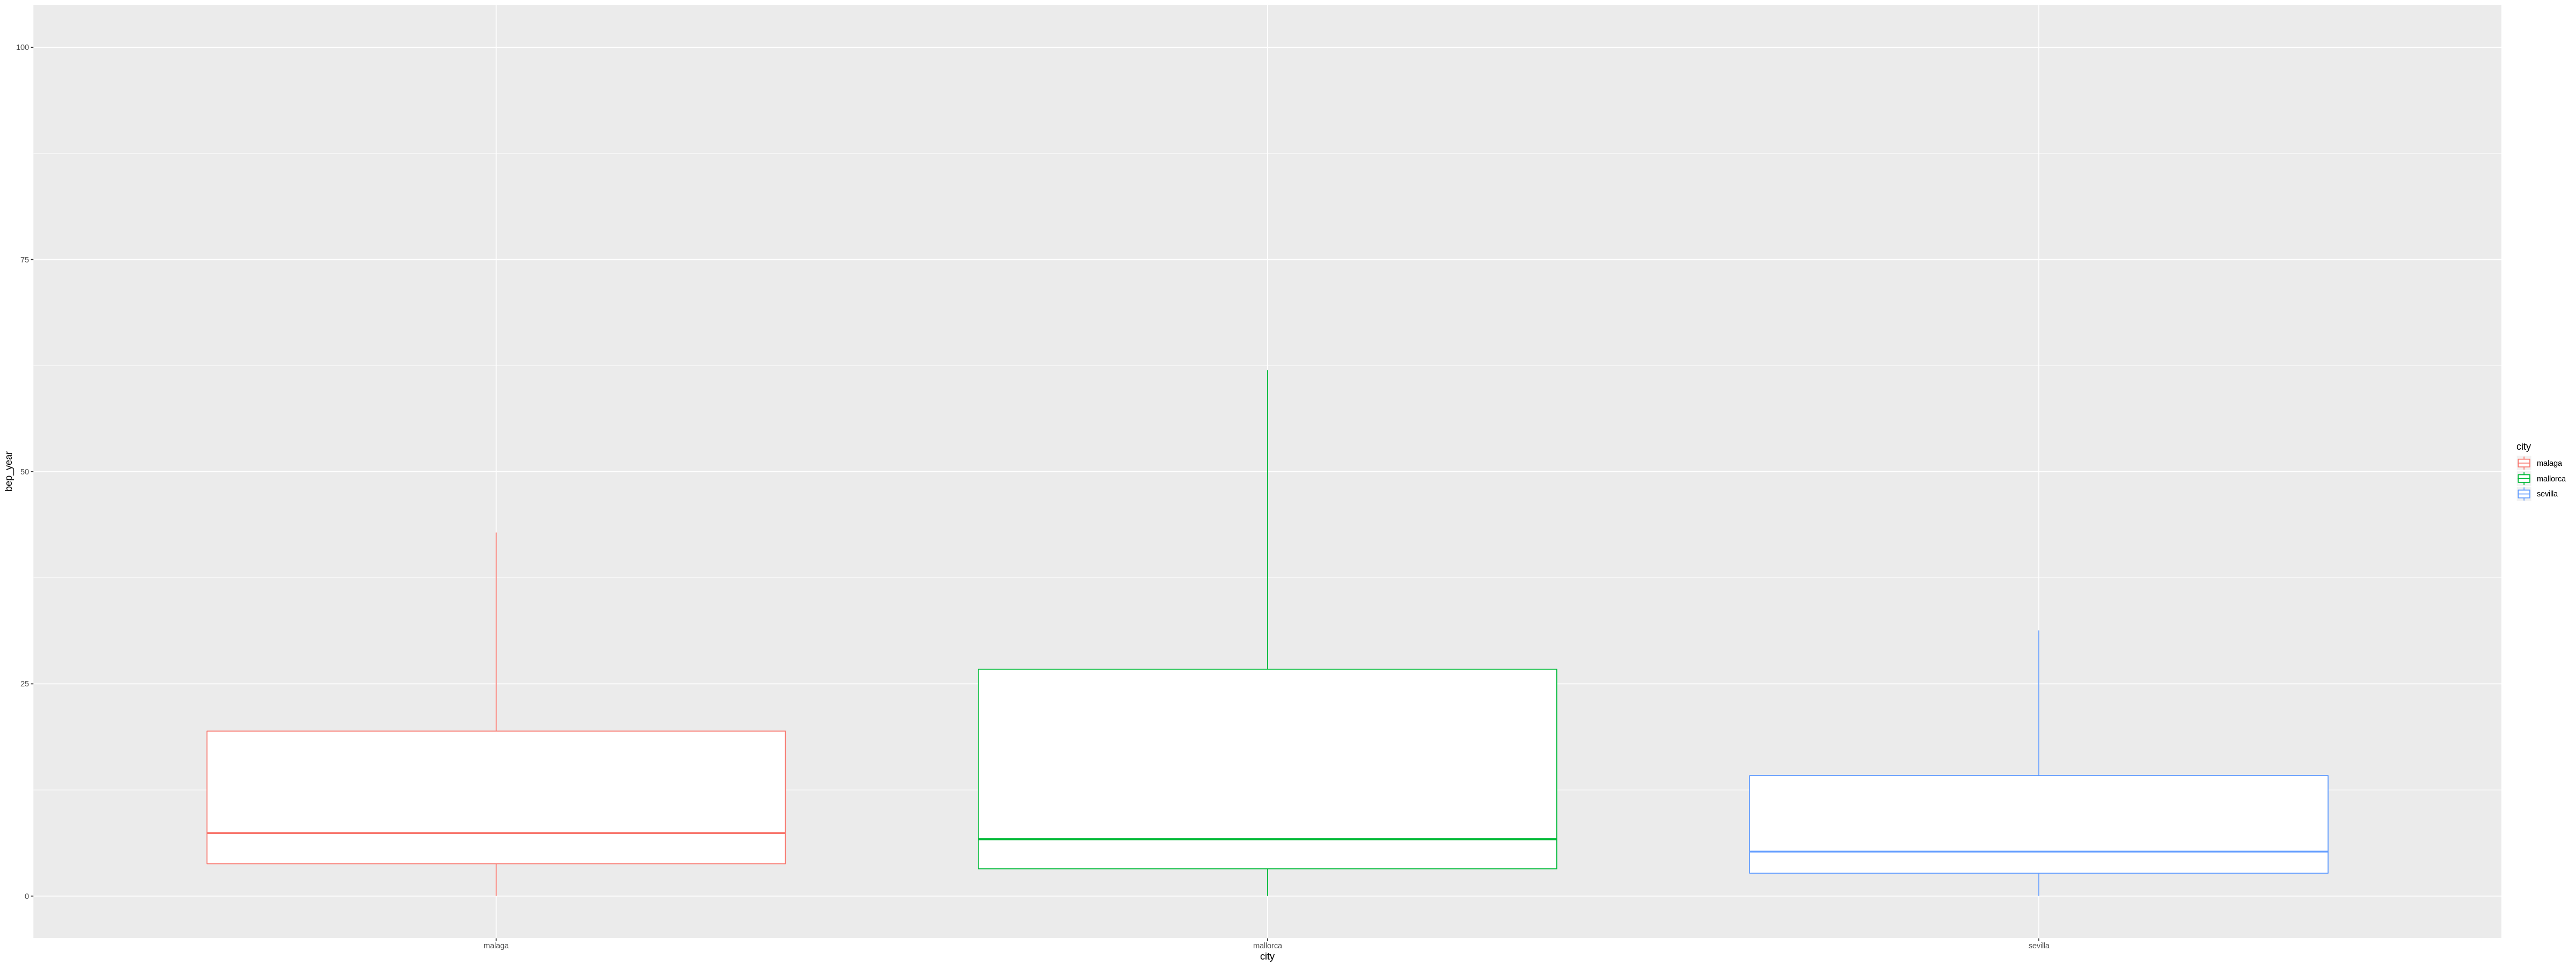

In [54]:
distrib_bep_year <- ggplot(listings_full, aes(city, bep_year))
distrib_bep_year + geom_boxplot(aes(colour = city), outlier.shape = NA) +
    scale_y_continuous(limits = quantile(listings$bep_turnover, c(0.1, 0.9), na.rm = T))